In [55]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from datetime import timedelta

In [14]:
item_spend = pd.read_csv("item_spend.csv")
player_activity = pd.read_csv("player_activity.csv")
player_statistics = pd.read_csv("player_statistics.csv")

item_spend.head()

,account_id,platform_id,occur_date,item,item_type,item_sub_type,money_spent
0,1295,PS4,2020/10/24,Imponte Dukes,CAR,MUSCLE,24734.421385
1,3820,PS4,2020/11/12,Vapid GB200,CAR,SPORTS,375005.743577
2,193,PS4,2020/11/27,Vulcar Warrener,CAR,SEDAN,47873.073648
3,4945,PS4,2020/11/27,Cheval Marshall,CAR,OFF ROAD,0.000000
4,4237,XBOX,2020/9/2,Albany V-STR,CAR,SPORTS,512640.830316


In [15]:
player_activity.head()

,account_id,platform_id,occur_date,activity_type,time_spent,kills,deaths,suicides,money_earned,rp_earned,success,money_vs_time_spent,rp_vs_time_spent
0,123,PC,2020-10-10,Nightclub Owner,2.421073,0,0,0,13847.602,497.001376,0,5720.025822,205.694462
1,6579,XBOX,2020-09-23,Heist,3.755906,0,0,0,0.000,331.334251,0,0.266247,88.483108
2,4223,XBOX,2020-09-07,Executive,1.075432,0,0,0,0.000,3512.143060,1,0.929859,3266.726894
3,1260,XBOX,2020-11-21,Heist,2.113035,0,0,0,0.000,497.001376,0,0.473253,235.680611
4,8638,XBOX,2020-09-03,Heist,3.183063,0,0,0,0.000,497.001376,0,0.314163,156.453512


In [16]:
player_statistics.head()

,account_id,platform_id,occur_date,ltd_days_played,first_day_played,evc_balance,pvc_balance,char_rank,daily_playtime,days_since_first
0,0,XBOX,2020-10-19,184.0,2019-05-11,405322.322322,0.0,35.0,0.124253,527
1,1,PS4,2020-10-19,154.0,2017-03-16,1686.933050,0.0,44.0,0.198681,1313
2,2,XBOX,2020-10-19,76.0,2020-02-08,235143.875599,0.0,20.0,1.962876,254
3,3,XBOX,2020-10-19,24.0,2015-10-14,141470.689852,0.0,20.0,0.865092,1832
4,4,XBOX,2020-10-19,579.0,2018-05-19,32.386267,0.0,99.0,1.133067,884


Hypothesis: Players who gradually decrease playtime and spending over time are more likely to quit.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE

# === 1. Load Data ===
player_statistics = pd.read_csv("player_statistics.csv")
item_spend = pd.read_csv("item_spend.csv")
player_activity = pd.read_csv("player_activity.csv")

# Convert date column to datetime format
player_statistics['occur_date'] = pd.to_datetime(player_statistics['occur_date'])
item_spend['occur_date'] = pd.to_datetime(item_spend['occur_date'])
player_activity['occur_date'] = pd.to_datetime(player_activity['occur_date'])

# === 2. Aggregate Data ===
# Aggregate item_spend: sum money spent per player per day
item_spend_agg = item_spend.groupby(["account_id", "platform_id", "occur_date"], as_index=False).agg({
    "money_spent": "sum"
})

# Aggregate player_activity: sum time spent, kills, deaths, money earned, and RP earned per player per day
player_activity_agg = player_activity.groupby(["account_id", "platform_id", "occur_date"], as_index=False).agg({
    "time_spent": "sum",
    "kills": "sum",
    "deaths": "sum",
    "suicides": "sum",
    "money_earned": "sum",
    "rp_earned": "sum",
    "success": "mean"  # Compute success rate (fraction of successful activities)
})

# === 3. Merge Aggregated Data with Player Statistics ===
df = player_statistics.merge(item_spend_agg, on=["account_id", "platform_id", "occur_date"], how="left")\
                      .merge(player_activity_agg, on=["account_id", "platform_id", "occur_date"], how="left")

# === 4. Add Additional Features ===
# Compute 7-day trends for spending, earnings, and playtime
df['playtime_change_7d'] = df.groupby('account_id')['daily_playtime'].diff(7).fillna(0)
df['spending_change_7d'] = df.groupby('account_id')['money_spent'].diff(7).fillna(0)
df['earned_money_change_7d'] = df.groupby('account_id')['money_earned'].diff(7).fillna(0)

# Compute additional engagement & progression features
df['success_rate'] = df.groupby('account_id')['success'].transform(lambda x: x.mean())
df['time_spent_std'] = df.groupby('account_id')['time_spent'].transform(lambda x: x.std())

# Fill missing values with 0 (for players who didn't spend or participate in activities daily)
df.fillna({
    'money_spent': 0, 
    'time_spent': 0, 
    'kills': 0, 
    'deaths': 0, 
    'suicides': 0, 
    'money_earned': 0, 
    'rp_earned': 0, 
    'success_rate': 0, 
    'time_spent_std': 0,
    'playtime_change_7d': 0,
    'spending_change_7d': 0,
    'earned_money_change_7d': 0
}, inplace=True)

# === 5. Add Churn Label (Inactive for N Days) ===
churn_days = 14  # Define churn as no activity for 14 days

# Get last active date per player
last_play_dates = df.groupby("account_id")["occur_date"].max().reset_index()
last_play_dates.columns = ["account_id", "last_play_date"]

# Get dataset max date
max_date = df["occur_date"].max()

# Define churn: If "last active date + churn_days" < max_date, player has churned
last_play_dates["churn"] = np.where(
    last_play_dates["last_play_date"] + pd.Timedelta(days=churn_days) < max_date, 1, 0
)

# Merge churn labels
df = df.merge(last_play_dates[["account_id", "churn"]], on="account_id", how="left")

# === 6. Sort Values for Consistency ===
df.sort_values(['account_id', 'occur_date'], inplace=True)

# === 7. Display Summary ===
print(f"玩家总数: {df['account_id'].nunique()}")  # 应该是 9,476
print(f"总数据量（每日记录）: {len(df)}")  # 应该是 9,476 × 90
print(f"流失玩家数: {df[df['churn'] == 1]['account_id'].nunique()}")  # 计算有churn=1的唯一玩家数

# Save merged dataset
df.to_csv("merged_player_data.csv", index=False)

#----------------------------------------------------------------

玩家总数: 9476
总数据量（每日记录）: 246137
流失玩家数: 2145


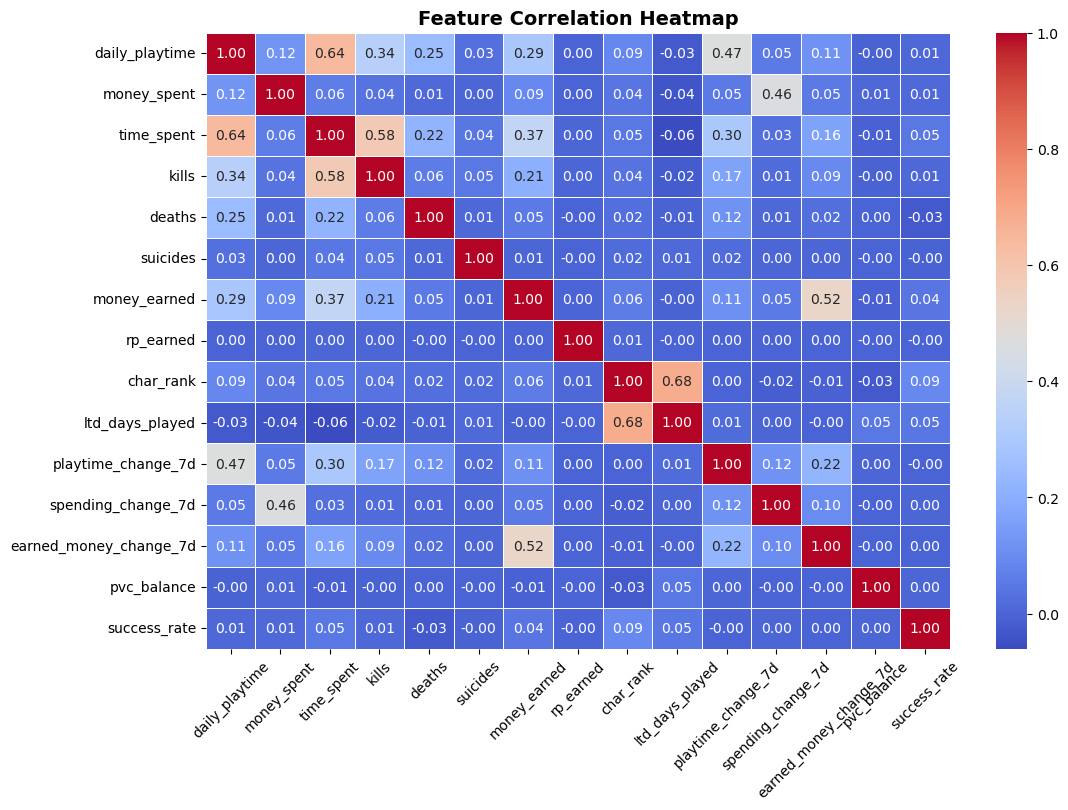

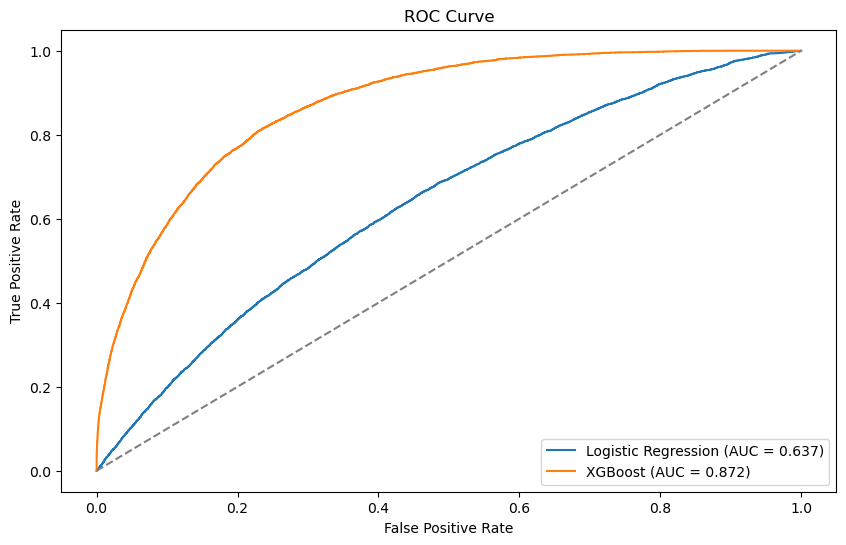

Best Threshold for Logistic Regression: 0.521
=== Logistic Regression (Optimized Threshold) ===
              precision    recall  f1-score   support

           0       0.90      0.54      0.67     41087
           1       0.20      0.66      0.31      7352

    accuracy                           0.56     48439
   macro avg       0.55      0.60      0.49     48439
weighted avg       0.79      0.56      0.62     48439

Best Threshold for XGBoost: 0.583
=== XGBoost (Optimized Threshold) ===
              precision    recall  f1-score   support

           0       0.96      0.77      0.85     41087
           1       0.39      0.81      0.52      7352

    accuracy                           0.78     48439
   macro avg       0.67      0.79      0.69     48439
weighted avg       0.87      0.78      0.80     48439



In [157]:
# === 1. 读取数据 ===
df = pd.read_csv("merged_player_data.csv")

# 转换日期列
df['occur_date'] = pd.to_datetime(df['occur_date'])

# === 2. 特征工程 ===
# 计算 7 天变化趋势
df['playtime_change_7d'] = df.groupby('account_id')['daily_playtime'].diff(7).fillna(0)
df['spending_change_7d'] = df.groupby('account_id')['money_spent'].diff(7).fillna(0)
df['earned_money_change_7d'] = df.groupby('account_id')['money_earned'].diff(7).fillna(0)

# 计算每个玩家的成功率
df['success_rate'] = df.groupby('account_id')['success'].transform(lambda x: x.mean())

# 选择最终特征
features = [
    'daily_playtime', 'money_spent', 'time_spent', 'kills', 'deaths',
    'suicides', 'money_earned', 'rp_earned', 'char_rank', 'ltd_days_played',
    'playtime_change_7d', 'spending_change_7d', 'earned_money_change_7d',
    'pvc_balance', 'success_rate'
]
target = 'churn'

# 删除包含缺失值的行
df = df.dropna(subset=features + [target])

# === 3. 计算相关性热图 ===
corr_matrix = df[features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# === 4. 训练集-测试集划分 ===
X = df[features]
y = df[target]

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 80% 训练，20% 测试
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# === 5. 处理类别不平衡（SMOTE 过采样） ===
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# === 6. 训练 Logistic Regression ===
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
logreg.fit(X_train_resampled, y_train_resampled)

# === 7. 训练 XGBoost ===
scale_pos_weight = 5
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss',
                    learning_rate=0.2, max_depth=7, n_estimators=500)
xgb.fit(X_train_resampled, y_train_resampled)

# === 8. 计算 ROC-AUC 并绘制 ROC 曲线 ===
def plot_roc_curve(models, X_test, y_test):
    """绘制不同模型的 ROC 曲线，并计算 AUC"""
    plt.figure(figsize=(10, 6))
    
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1]  # 预测概率
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 随机模型的参考线
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 计算并绘制 ROC-AUC
models = {
    "Logistic Regression": logreg,
    "XGBoost": xgb
}
plot_roc_curve(models, X_test, y_test)

# === 9. 计算最优阈值 ===
def find_best_threshold(model, X_test, y_test):
    """找到最佳分类阈值"""
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    best_threshold = thresholds[np.argmax(tpr - fpr)]  # Youden's J statistic
    return best_threshold

best_threshold_logreg = find_best_threshold(logreg, X_test, y_test)
y_probs_logreg = logreg.predict_proba(X_test)[:, 1]
y_pred_logreg_adjusted = (y_probs_logreg > best_threshold_logreg).astype(int)

best_threshold_xgb = find_best_threshold(xgb, X_test, y_test)
y_probs_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_adjusted = (y_probs_xgb > best_threshold_xgb).astype(int)

# === 10. 评估模型性能 ===
print(f"Best Threshold for Logistic Regression: {best_threshold_logreg:.3f}")
print("=== Logistic Regression (Optimized Threshold) ===")
print(classification_report(y_test, y_pred_logreg_adjusted))

print(f"Best Threshold for XGBoost: {best_threshold_xgb:.3f}")
print("=== XGBoost (Optimized Threshold) ===")
print(classification_report(y_test, y_pred_xgb_adjusted))


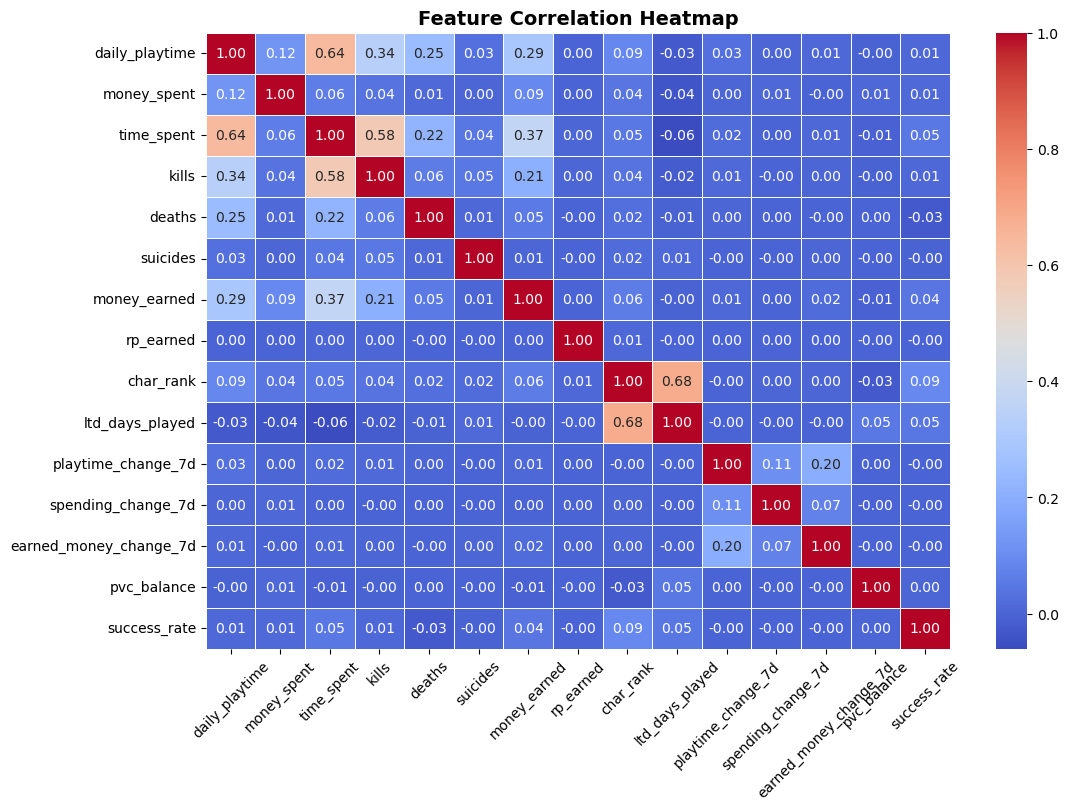

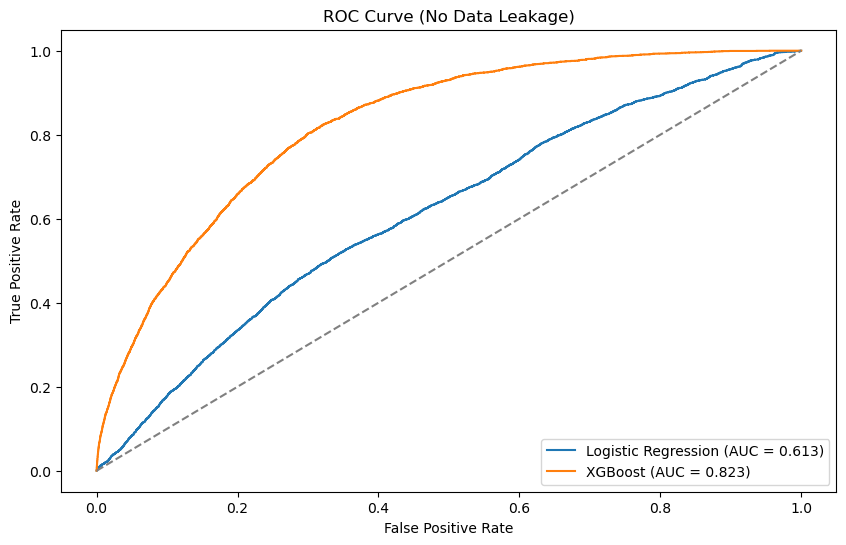

Best Threshold for Logistic Regression (No Data Leakage): 0.552
=== Logistic Regression (No Data Leakage) ===
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     83414
           1       0.06      0.51      0.11      3545

    accuracy                           0.66     86959
   macro avg       0.52      0.59      0.45     86959
weighted avg       0.93      0.66      0.76     86959

Best Threshold for XGBoost (No Data Leakage): 0.322
=== XGBoost (No Data Leakage) ===
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     83414
           1       0.10      0.80      0.18      3545

    accuracy                           0.70     86959
   macro avg       0.55      0.75      0.50     86959
weighted avg       0.95      0.70      0.79     86959



In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report

# === 1. 读取数据 ===
df = pd.read_csv("merged_player_data.csv")

# 转换日期列
df['occur_date'] = pd.to_datetime(df['occur_date'])

# === 2. 特征工程 ===
# 修正 7 天趋势计算，确保不使用未来数据
df['playtime_change_7d'] = df.groupby('account_id')['daily_playtime'].shift(7).diff().fillna(0)
df['spending_change_7d'] = df.groupby('account_id')['money_spent'].shift(7).diff().fillna(0)
df['earned_money_change_7d'] = df.groupby('account_id')['money_earned'].shift(7).diff().fillna(0)

# 计算每个玩家的成功率
df['success_rate'] = df.groupby('account_id')['success'].transform(lambda x: x.mean())

# 选择最终特征
features = [
    'daily_playtime', 'money_spent', 'time_spent', 'kills', 'deaths',
    'suicides', 'money_earned', 'rp_earned', 'char_rank', 'ltd_days_played',
    'playtime_change_7d', 'spending_change_7d', 'earned_money_change_7d',
    'pvc_balance', 'success_rate'
]
target = 'churn'

# 删除包含缺失值的行
df = df.dropna(subset=features + [target])

# === 3. 计算相关性热图 ===
corr_matrix = df[features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# === 4. 按时间划分训练集和测试集（避免数据泄漏） ===
train_cutoff = df['occur_date'].max() - pd.Timedelta(days=30)  # 只用最后 30 天的数据做测试
df_train = df[df['occur_date'] <= train_cutoff]
df_test = df[df['occur_date'] > train_cutoff]

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. 训练 Logistic Regression（无 SMOTE） ===
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

# === 6. 训练 XGBoost（无 SMOTE） ===
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)  # 根据真实类别比例计算 class weight
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss',
                    learning_rate=0.2, max_depth=7, n_estimators=500)
xgb.fit(X_train_scaled, y_train)

# === 7. 计算 ROC-AUC 并绘制 ROC 曲线 ===
def plot_roc_curve(models, X_test, y_test):
    """绘制不同模型的 ROC 曲线，并计算 AUC"""
    plt.figure(figsize=(10, 6))
    
    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1]  # 预测概率
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 随机模型的参考线
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (No Data Leakage)")
    plt.legend(loc="lower right")
    plt.show()

# 计算并绘制 ROC-AUC
models = {
    "Logistic Regression": logreg,
    "XGBoost": xgb
}
plot_roc_curve(models, X_test_scaled, y_test)

# === 8. 计算最优阈值（无数据泄漏） ===
def find_best_threshold(model, X_test, y_test):
    """找到最佳分类阈值"""
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    best_threshold = thresholds[np.argmax(tpr - fpr)]  # Youden's J statistic
    return best_threshold

best_threshold_logreg = find_best_threshold(logreg, X_test_scaled, y_test)
y_probs_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred_logreg_adjusted = (y_probs_logreg > best_threshold_logreg).astype(int)

best_threshold_xgb = find_best_threshold(xgb, X_test_scaled, y_test)
y_probs_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb_adjusted = (y_probs_xgb > best_threshold_xgb).astype(int)

# === 9. 评估模型性能（无数据泄漏） ===
print(f"Best Threshold for Logistic Regression (No Data Leakage): {best_threshold_logreg:.3f}")
print("=== Logistic Regression (No Data Leakage) ===")
print(classification_report(y_test, y_pred_logreg_adjusted))

print(f"Best Threshold for XGBoost (No Data Leakage): {best_threshold_xgb:.3f}")
print("=== XGBoost (No Data Leakage) ===")
print(classification_report(y_test, y_pred_xgb_adjusted))
